In [ ]:
import ujson

summaries = {}
ctr = 0
for line in open('user_project_summaries.json'): # lazy iteration because the file is large
    print ctr,
    ctr+=1
    summaries.update(ujson.loads(line))

0 1 2 3 4 5 6 7 8 9

## Project names

### Morphological analysis

Use a morphological analyzer to learn to split project names.

In [2]:
with open('projectnames.txt', 'w') as o:
    for userid in summaries:
        for projectid in summaries[userid]:
            o.write(summaries[userid][projectid]['**Project Name'].replace('_', ' ')+' ') # _ usually separates morphemes

In [23]:
import morfessor
io = morfessor.MorfessorIO()
train_data = io.read_corpus_file('projectnames.txt')
model_tokens = morfessor.BaselineModel()
model_tokens.load_data(train_data)
model_tokens.train_batch()

KeyboardInterrupt: 

In [30]:
from collections import Counter

pnames = Counter(open('projectnames.txt').read().split())
print 'Loaded set of', len(pnames), 'project names'

Loaded set of 484526 project names


In [5]:
segpnames = [model_tokens.viterbi_segment(word) for word in pnames]

In [6]:
for segpname, _ in segpnames[:50]:
    print segpname,

['Phone', 'AccessLab'] ['BtCarEmuLab'] ['BN103096', 'Voice', 'Dict'] ['BN103096', 'Mole'] ['BN103096', 'L', 'AP', '01'] ['BN103096', 'Lab', '03', '05'] ['BtOX', 'Game', 'Lab', 'V1'] ['Screen', '4'] ['BN103', '09', '7', 'EX05', '07', '02'] ['BN103096', 'T2', 'S'] ['BN103096', '1'] ['BN103', '2', '99', 'Lab', '03', '05'] ['Block', '_', 'Lab', '00'] ['BN103096'] ['BN103096', 'OddEven'] ['BN103096', 'ST', 'ER'] ['BN103096', 'AA', '01'] ['BN103096', 'Sensor', '1'] ['BN103', '02', 'MD', '01'] ['BN103096', 'EX05', '07', '02'] ['BN103', '02', 'MD', '03'] ['WebViewer', 'Lab'] ['Lotto', '1111', 'Lab'] ['BN103096', 'Ex040901', '09', '02'] ['Web', 'AccessLab'] ['BN103', '2', '99', 'Roll', 'er', '2'] ['MusicPlayer', '2', 'Lab'] ['BN103096', 'BN103', '100'] ['Bluetooth', 'Lab1'] ['BN103096', 'Click'] ['BN103096', 'Demo', '01'] ['Lab', '00'] ['BN103096', 'Ex05', '07', '01'] ['BN103096', 'game', 'ox'] ['bn103096', 'clock'] ['BN103096', '_', 'MusicPlayer', 'Lab'] ['BN103096', 'Ex05', '07', '02'] ['BtCa

Does this give anything reasonable? Remains to be explored. Might need some parameter tweaking.

### Clustering

Cluster the project names using edit distance.

In [31]:
import leven
from sklearn.cluster import AffinityPropagation
import numpy as np

pnames_subset = [pname for pname, _ in pnames.most_common(5000)]

lev_aff = np.zeros((len(pnames_subset), len(pnames_subset)))
for i, pnamei in enumerate(pnames_subset):
    if i%100==0:
        print '.',
    for j, pnamej in enumerate(pnames_subset):
        if j>i:
            lev_aff[i, j] = -1*leven.levenshtein(pnamei, pnamej)
        elif j==i:
            lev_aff[i, j] = 0
        else:
            lev_aff[i, j] = lev_aff[j, i]
print 'Computed pairwise edit distances'

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Computed pairwise edit distances


In [32]:
model = AffinityPropagation(affinity="precomputed")
model.fit(lev_aff)
print 'Fit affinity propagator'

Fit affinity propagator


In [34]:
from collections import defaultdict
exemplars = defaultdict(list)
for i, clustid in enumerate(model.labels_):
    exem = model.cluster_centers_indices_[clustid]
    exemplars[pnames_subset[exem]].append(pnames_subset[i])
    
# look at a sample
for exem in exemplars.keys()[:30]:
    print exem, exemplars[exem]

Canvas ['Canvas', 'canvas', 'CanvasDraw', 'CanvasClock', 'CanvasFlung', 'canvas2', 'canvas1', 'lanzado', 'Carlos', 'Canvas2', 'Canvas1']
Soundboard ['Soundboard', 'SoundBoard', 'soundboard', 'MLGsoundboard', 'download', 'SoundboardApp', 'SoundBoardApp']
takepicturetest ['takepicturetest']
ActivityStarter ['ActivityStarter', 'activitystarter']
Texting ['Texting', 'texting', 'testing', 'NoTexting', 'Testing', 'TextDialog', 'Snelling', 'notexting', 'TextingApp', 'fertig']
four ['for', 'Tour', 'tour', 'Your', 'four', 'your', 'Touch', 'Group', 'You', 'fourth']
Notetaker ['NoteTaker', 'QRCodeMaker', 'notetaker', 'Notetaker']
luckyvassuBMICalculator ['luckyvassuBMICalculator']
ShowAlert ['ShowAlert', 'showalert']
CoinFlipMediaOnly ['PaintPotMediaOnly', 'CoinFlipMediaOnly']
PaintPotExtended ['PaintPotExtended']
Trivia ['adivina', 'driving', 'Trivia', 'Adivina', 'trivia', 'TriviaQuiz']
mediaboard ['MediaBoard', 'clipboard', 'mediaboard']
UniversalScreenSize ['UniversalScreenSize']
ver ['For', '

Unclear whether these clusters are meaningful, BUT we can very that later by looking at the code.

## Language Identification from Variable Names

Predict the native language of a user from their variable names and strings.

In [12]:
import langid
from collections import defaultdict

user_tokens = defaultdict(list)
for i, userid in enumerate(summaries):
    if (i+1)%100==0:
        print '.',
    if (i+1)%5000==0:
        print i+1
    for projectid in summaries[userid]:
        numscreens = summaries[userid][projectid]['*Number of Screens']
        for screenid in range(numscreens):
            screentitle = 'Screen'+str(screenid+1)
            if screentitle in summaries[userid][projectid]:
                # blocks
                if summaries[userid][projectid][screentitle]['Blocks']=='NO BLOCKS':
                    continue
                blocks = summaries[userid][projectid][screentitle]['Blocks']
                if blocks == 'MALFORMED BKYFILE':
                    continue
                if blocks['Active Blocks']=='NO ACTIVE BLOCKS':
                    continue
                for namesp in ['Global Variable Names', 'Procedure Names', 'Procedure Parameter Names', 'Strings']:
                    for vname in blocks['Active Blocks'][namesp]:
                        user_tokens[userid].append(vname)
                # components
                if summaries[userid][projectid][screentitle]['Components']=='N':
                    continue
                for sname in summaries[userid][projectid][screentitle]['Components']['Strings']:
                    user_tokens[userid].append(sname)
            

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [14]:
from collections import defaultdict, Counter

user_langs = defaultdict(lambda : defaultdict(float))
for i, userid in enumerate(user_tokens):
    if (i+1)%100==0:
        print '.',
    if (i+1)%5000==0:
        print i+1
        
    if len(user_tokens[userid])<50:
        print '*',
        continue
    user_langs[userid] = langid.classify(' '.join(user_tokens[userid]))[0]

with open('user_inferredlangs.json', 'w') as o:
    ujson.dump(user_langs, o)

 . * . * * * . * * . * * . * * * . * . * . * * . * * . * * . . * * * . . * . * * . * * * . * * . * . * * . * * . * * . * . * * * . . * * . * * * . . * . * * * . * * . * * * . * . * * . . * . * * * . . . . * * * * * * * . * * * . * * . . * . * * * * . * . . * * . * * . 5000
* * . * . * * . * * * * . * * . * * * . * * * * . * * * . * . * * . * * * * . * * . * . . * * . . * * . * . . * . * * * . * * . * * * * . * . * * . * . * * * . * . * . . * . . * . * * * . * * . * . . . * * * * . * * . * . * . * * . * * . * * . * * * . * * . * * * * * . * . * * . 10000
* . * . . . . * . * * . . * . * . . * . * . . * * * . * . * * . * * . * . . * * * . * . * * . * * . . * . . * * . * . * * . * * * * * * . * * . * * . * . * * . . * . * . * * * . * * . * * * * * . . * * * * . . * . * * * . * * . . * * * . . 15000
. * * * * . . * . . * . . * . * . . . . * . . * * * . * * * . * * . * . . . * . * * * . * * * . * . * . * * * . . * * . . * * . * * . * * * . * . * . . . * * * . * * . * . * . . * * * . . * * . 

45505 total users


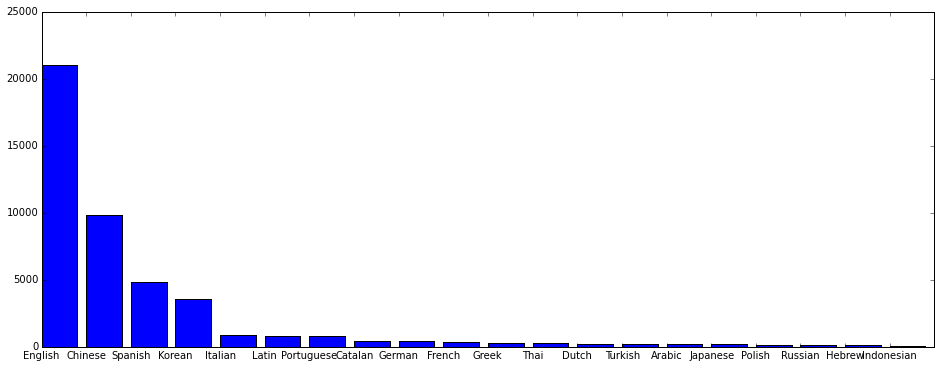

In [22]:
iso = ujson.load(open('isocodes.json'))

langcounts = Counter(user_langs.values())
print sum(langcounts.values()), 'total users'

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
matplotlib.rcParams['figure.figsize'] = (16, 6)

common_langcounts_keys, common_langcounts_values = zip(*langcounts.most_common(20))
common_langcounts_keys = [iso[code] for code in common_langcounts_keys]

plt.bar(range(len(common_langcounts_keys)), common_langcounts_values)
x = plt.xticks(range(len(common_langcounts_keys)), common_langcounts_keys)

The "Latin" users are suspicious. Needs further investigation.